In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install torch==1.4.0 torchvision==0.5.0

# install mmcv-full thus we could use CUDA operators
!pip install mmcv==0.4.3

!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!git checkout 8732ed9
!pip install -r requirements/build.txt
!pip install "git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI"
!pip install -v -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

     |████████████████████████████████| 753.4 MB 7.0 kB/s 
     |████████████████████████████████| 4.0 MB 37.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.
     |████████████████████████████████| 53 kB 2.5 MB/s 
  Created wheel for mmcv: filename=mmcv-0.4.3-cp37-cp37m-linux_x86_64.whl size=171252 sha256=110d65871c3e3d8f9ef325d43725192989140fa81eb7e57be727f78ca5cec3de
  Stored in directory: /root/.cache/pip/wheels/

     |████████████████████████████████| 2.1 MB 8.6 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 7.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
mmdet 1.1.0+8732ed9 requires Pillow<=6.2.2, but you have pillow 7.0.0 which is incompatible.


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

1.4.0 True
1.1.0+8732ed9


In [ ]:
!wget https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz

!tar -xzf /content/ShelfImages.tar.gz
!rm /content/ShelfImages.tar.gz

!wget https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv

import os
test = os.listdir("/content/ShelfImages/test")
train = os.listdir("/content/ShelfImages/train")

import pandas as pd
df = pd.read_csv('/content/annotations.csv',names=["filename","xmin","ymin","xmax","ymax","class"]) 

df['class'] = 1
df['class'].value_counts()

train_anno=df[df['filename'].isin(train)]
test_anno=df[df['filename'].isin(test)]

--2021-08-15 07:23:19--  https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580345649 (553M) [application/gzip]
Saving to: ‘ShelfImages.tar.gz’

ShelfImages.tar.gz  100%[===================>] 553.46M   147MB/s    in 4.5s    

2021-08-15 07:23:24 (122 MB/s) - ‘ShelfImages.tar.gz’ saved [580345649/580345649]

--2021-08-15 07:23:29--  https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517978 (506K) [text/p

In [ ]:
import numpy as np
import json
import pandas as pd
import cv2

di = {"instances_train.json":train_anno,"instances_test.json":test_anno}

for i in ["instances_train.json","instances_test.json"]:
  save_json_path = i #output path to the json
  data = di[i]
  images = []
  categories = []
  annotations = []

  category = {}
  category["supercategory"] = 'none'
  category["id"] = 0
  category["name"] = 'None'
  categories.append(category)

  data['fileid'] = data['filename'].astype('category').cat.codes
  data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
  data['categoryid'] = data['categoryid']+1
  data['annid'] = data.index

  def image(row):
    image = {}
    im = cv2.imread("ShelfImages/"+i[i.index("_")+1:i.index(".")]+"/"+row.filename)
    image["height"] = im.shape[0]
    image["width"] = im.shape[1]
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

  def category(row):
    category = {}
    category["supercategory"] = 'Product'
    print(row)
    category["id"] = row.categoryid
    category["name"] = 'Product'
    return category

  def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

  for row in data.itertuples():
    annotations.append(annotation(row))

  imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
  for row in imagedf.itertuples():
    images.append(image(row))

  catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
  for row in catdf.itertuples():
    categories.append(category(row))

  data_coco = {}
  data_coco["images"] = images
  data_coco["categories"] = categories
  data_coco["annotations"] = annotations
  json.dump(data_coco, open(save_json_path, "w"), indent=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Pandas(Index=0, filename='C1_P01_N1_S2_1.JPG', xmin=1008, ymin=1552, xmax=1260, ymax=1928, _6=1, fileid=0, categoryid=1, annid=0)
Pandas(Index=238, filename='C1_P02_N1_S5_1.JPG', xmin=1032, ymin=2080, xmax=1204, ymax=2408, _6=1, fileid=0, categoryid=1, annid=238)


In [ ]:
!git clone https://github.com/yan-roo/SpineNet-Pytorch.git
%cd SpineNet-Pytorch

Cloning into 'SpineNet-Pytorch'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 176 (delta 98), reused 120 (delta 60), pack-reused 0
Receiving objects: 100% (176/176), 2.05 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/SpineNet-Pytorch


In [ ]:
!cp -r /content/SpineNet-Pytorch/mmdet /content/mmdetection
!cp -r /content/SpineNet-Pytorch/configs/ /content/mmdetection

In [ ]:
%cd /content/mmdetection

/content/mmdetection


In [ ]:
%set_env CONFIG_FILE=/content/mmdetection/configs/spinenet/spinenet_49_B_8gpu_896.py
!python tools/train.py ${CONFIG_FILE}

env: CONFIG_FILE=/content/mmdetection/configs/spinenet/spinenet_49_B_8gpu_896.py
2021-08-15 07:29:51,766 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.11 (default, Jul  3 2021, 18:01:19) [GCC 7.5.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GPU 0: Tesla T4
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.4.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gen

In [ ]:
%set_env CONFIG_FILE=/content/mmdetection/configs/spinenet/spinenet_49_B_8gpu_896.py
!python tools/train.py ${CONFIG_FILE} --resume_from /content/mmdetection/work_dirs/spinenet_49_B_896/epoch_75.pth --validate

env: CONFIG_FILE=/content/mmdetection/configs/spinenet/spinenet_49_B_8gpu_896.py
2021-08-15 09:22:39,537 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.11 (default, Jul  3 2021, 18:01:19) [GCC 7.5.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.0_bu.TC445_37.28845127_0
GPU 0: Tesla T4
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.4.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gen

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

In [ ]:
config_file = '/content/mmdetection/configs/spinenet/spinenet_49_B_8gpu_896.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
checkpoint_file = '/content/mmdetection/work_dirs/spinenet_49_B_896/latest.pth'

In [ ]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [ ]:
img = '/content/ShelfImages/test/C3_P04_N1_S4_1.JPG'
result = inference_detector(model, img)

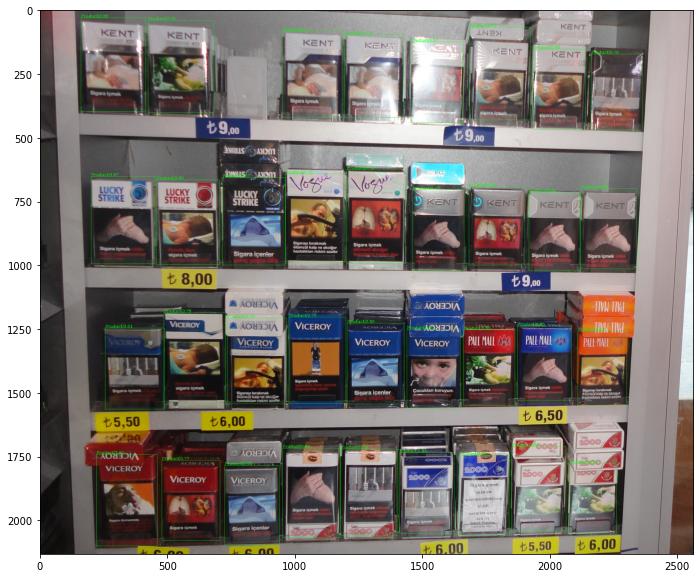

In [ ]:
show_result_pyplot(img, result, model.CLASSES, 0.3)